# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Read in Data and Split in Test and Train

In [2]:
df = pd.read_csv("bank+marketing/bank/bank_preprocessed.csv")
X = df.drop(columns = "y")
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
print ("Number of training examples: " + str(X_train.shape[0]))
print ("Number of testing examples: " + str( X_test.shape[0]))
print ("Number of features = " + str(X_train.shape[1]))

Number of training examples: 3616
Number of testing examples: 905
Number of features = 43


# Define Functions for Neural Network

In [60]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy

    Arguments:
    Z -- output of the linear layer, of any shape

    Returns:
    A -- output of the sigmoid function, of the same shape as Z
    cache -- returns Z as well, stored for computing the backward pass efficiently
    """
    Z = np.array(Z, dtype=np.float64) 
    
    A = 1/(1+np.exp(-Z))
    
    assert(A.shape == Z.shape)
    
    cache = Z
    
    return A, cache


def relu(Z):
    """
    Implements the ReLU activation in numpy

    Arguments:
    Z -- output of the linear layer, of any shape

    Returns:
    A -- output of the ReLU function, of the same shape as Z
    cache -- returns Z as well, stored for computing the backward pass efficiently
    """
    Z = np.array(Z, dtype=np.float64) 
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z
    
    return A, cache

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W,A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  

    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(
            A_prev,
            parameters["W" + str(l)],
            parameters["b" + str(l)],
            activation="relu"
        )
        caches.append(cache)

    AL, cache = linear_activation_forward(
        A,
        parameters["W" + str(L)],
        parameters["b" + str(L)],
        activation="sigmoid"
    )
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches


def compute_cost(AL, Y, class_weights=None):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    if class_weights:
        w_0, w_1 = class_weights[0], class_weights[1]
        cost = -1/m * np.sum(w_1 * Y * np.log(AL) + w_0 * (1 - Y) * np.log(1 - AL))
    else:
        cost = -1/m * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert(dA_prev.shape == A_prev.shape)
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)

    return dA_prev, dW, db

def sigmoid_backward(dA, activation_cache):
    """
    Implementiert den Backward-Schritt für die Sigmoid-Aktivierungsfunktion.

    Argumente:
    dA -- Ableitung des Kostenwerts bezogen auf die Aktivierung (nach der Sigmoid-Funktion)
    activation_cache -- enthält Z, den linearen Voraktivierungswert (kommt aus forward step)

    Rückgabe:
    dZ -- Ableitung des Kostenwerts bezogen auf Z
    """
    Z = activation_cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    return dZ

def relu_backward(dA, activation_cache):
    """
    Implementiert den Backward-Schritt für die ReLU-Aktivierungsfunktion.

    Argumente:
    dA -- Ableitung des Kostenwerts bezogen auf die Aktivierung (nach der ReLU-Funktion)
    activation_cache -- enthält Z, den linearen Voraktivierungswert (kommt aus forward step)

    Rückgabe:
    dZ -- Ableitung des Kostenwerts bezogen auf Z
    """
    Z = activation_cache
    dZ = np.array(dA, copy=True)  # kopiere dA als Basis für dZ
    dZ[Z <= 0] = 0
    return dZ


def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L - 1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = \
        linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = \
            linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads


def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

In [61]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False, class_weights=None):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []
    
    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y, class_weights)
    
        grads = L_model_backward(AL, Y, caches)
 
        parameters = update_parameters(parameters, grads, learning_rate)
                
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
            
    if print_cost:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

In [6]:
def predict(X, y_true, parameters):
    """
    Diese Funktion verwendet die gelernten Parameter, um Vorhersagen zu machen.
    
    Argumente:
    X -- Eingabedaten (Features), numpy array der Form (input size, number of examples)
    y -- Wahre Labels, numpy array der Form (1, number of examples)
    parameters -- Gelernte Gewichte und Biases

    Rückgabe:
    predictions -- binäre Vorhersagen (0 oder 1)
    """

    AL, _ = L_model_forward(X, parameters)

    predictions = (AL > 0.5).astype(int)

    return predictions


# Normalize Standardize input

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_train = y_train.reshape(1, y_train.shape[0])
y_test = y_test.to_numpy()
y_test = y_test.reshape(1, y_test.shape[0])
X_train = X_train.T
X_test = X_test.T
X_train_scaled = X_train_scaled.T
X_test_scaled = X_test_scaled.T

In [9]:
y_train.shape

(1, 3616)

# Apply to data

### Berechne auf Skalierten Daten

 Berechnung mit Nicht-Normierten Daten ist nicht möglich!

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.601264
Cost after iteration 200: 0.537712
Cost after iteration 300: 0.493142
Cost after iteration 400: 0.461337
Cost after iteration 500: 0.438232
Cost after iteration 600: 0.421161
Cost after iteration 700: 0.408350
Cost after iteration 800: 0.398603
Cost after iteration 900: 0.391094
Cost after iteration 1000: 0.385247
Cost after iteration 1100: 0.380650
Cost after iteration 1200: 0.377005
Cost after iteration 1300: 0.374093
Cost after iteration 1400: 0.371751
Cost after iteration 1500: 0.369856
Cost after iteration 1600: 0.368316
Cost after iteration 1700: 0.367058
Cost after iteration 1800: 0.366025
Cost after iteration 1900: 0.365175
Cost after iteration 2000: 0.364472
Cost after iteration 2100: 0.363890
Cost after iteration 2200: 0.363406
Cost after iteration 2300: 0.363003
Cost after iteration 2400: 0.362666


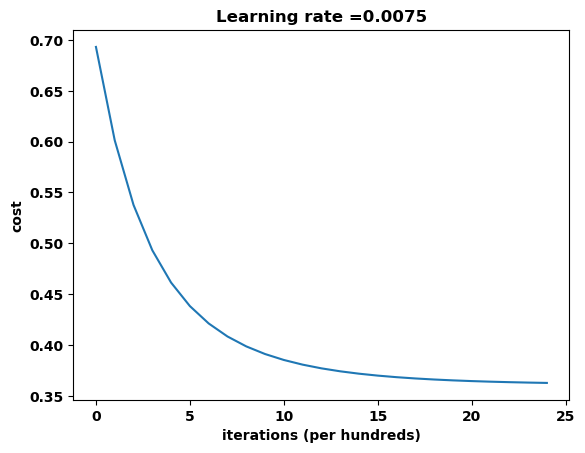

In [10]:
layers_dims = [43, 20, 7, 5, 1]
parameters = L_layer_model(X_train_scaled, y_train, layers_dims, num_iterations = 2500, print_cost = True)


In [11]:
predictions = predict(X_test_scaled, y_test, parameters)

Schränke Parameter ein  

In [17]:
results = []  
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
layers_dims_list = [[43, 16, 10, 1],[43, 13, 13, 1],[43, 20, 6, 1],[43, 12, 8, 6, 1],[43, 10, 10, 6, 1],[43, 14, 7, 5, 1],[43, 8, 6, 6, 6, 1],[43, 7, 7, 6, 6, 1]]
num_iterations = 2500

print(len(layers_dims_list)* len(learning_rates), "models to be trained")

for lr in learning_rates:
    predictions = np.zeros((1, X_test.shape[1]))
    for layers_dims in layers_dims_list:
        parameters = L_layer_model(X_train_scaled, y_train, layers_dims, learning_rate=lr, num_iterations = 2500, print_cost = False)
        predictions = predict(X_test_scaled, y_test, parameters)
        y_pred = pd.Series(predictions[0].flatten())
        try:
            roc_value = roc_auc_score(y_test.flatten(), y_pred)
        except ValueError as e:
            print("ROC AUC skipped due to error:", e)
            continue
        
        if predictions.sum() > 1 and roc_value > 0.5:
            results.append({
                "layer_dims": layers_dims,
                "num_iterations": num_iterations,
                "learning_rate": lr,
                "parameters": parameters,
                "roc_auc": np.round(roc_value,3),
                "predictions": predictions
            })

40 models to be trained


In [19]:
print("Gefundene Kombinationen")
for result in results:
    print(f"layer_dims: {result['layer_dims']}, learning_rate: {result['learning_rate']}, roc_auc: {result['roc_auc']}")

Gefundene Kombinationen
layer_dims: [43, 16, 10, 1], learning_rate: 0.1, roc_auc: 0.64
layer_dims: [43, 13, 13, 1], learning_rate: 0.1, roc_auc: 0.643
layer_dims: [43, 20, 6, 1], learning_rate: 0.1, roc_auc: 0.666


In [42]:
results = []  
learning_rates = [0.12, 0.11, 0.1, 0.09]
layers_dims_list = [
[43, 20, 6, 4, 1],
[43, 20, 6, 1],
[43, 18, 6, 1],
[43, 16, 10, 1],
[43, 14, 8, 1],
[43, 8, 5, 1]
]
num_iterations = 10000

print(len(layers_dims_list)* len(learning_rates), "models to be trained")

for lr in learning_rates:
    predictions = np.zeros((1, X_test.shape[1]))
    for layers_dims in layers_dims_list:
        parameters = L_layer_model(X_train_scaled, y_train, layers_dims, learning_rate=lr, num_iterations = 2500, print_cost = False)
        predictions = predict(X_test_scaled, y_test, parameters)
        y_pred = pd.Series(predictions[0].flatten())
        try:
            roc_value = roc_auc_score(y_test.flatten(), y_pred)
        except ValueError as e:
            print("ROC AUC skipped due to error:", e)
            continue
        
        if predictions.sum() > 1 and roc_value > 0.5:
            results.append({
                "layer_dims": layers_dims,
                "num_iterations": num_iterations,
                "learning_rate": lr,
                "parameters": parameters,
                "roc_auc": np.round(roc_value,3),
                "predictions": predictions
            })

24 models to be trained


In [45]:
print("Gefundene Kombinationen")
res = pd.DataFrame(results).sort_values(by="roc_auc", ascending=False).reset_index(drop=True).head(10)
res.head()

Gefundene Kombinationen


,layer_dims,num_iterations,learning_rate,parameters,roc_auc,predictions
0,"[43, 20, 6, 1]",10000,0.11,"{'W1': [[0.04125089338725916, -0.0138006413731...",0.671,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."
1,"[43, 20, 6, 1]",10000,0.12,"{'W1': [[0.05109037186872394, -0.0175934033092...",0.670,"[[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,..."
2,"[43, 20, 6, 1]",10000,0.10,"{'W1': [[0.030644981625543105, -0.013055601049...",0.666,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."
3,"[43, 16, 10, 1]",10000,0.11,"{'W1': [[0.019730039068007774, 0.0111722895260...",0.660,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."
4,"[43, 20, 6, 1]",10000,0.09,"{'W1': [[0.024131214510471944, -0.009898854637...",0.657,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."


# Berechne Model für beste Parameter

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.370181
Cost after iteration 200: 0.361569
Cost after iteration 300: 0.360927
Cost after iteration 400: 0.360866
Cost after iteration 500: 0.360859
Cost after iteration 600: 0.360856
Cost after iteration 700: 0.360853
Cost after iteration 800: 0.360848
Cost after iteration 900: 0.360843
Cost after iteration 1000: 0.360835
Cost after iteration 1100: 0.360823
Cost after iteration 1200: 0.360803
Cost after iteration 1300: 0.360771
Cost after iteration 1400: 0.360715
Cost after iteration 1500: 0.360617
Cost after iteration 1600: 0.360442
Cost after iteration 1700: 0.360100
Cost after iteration 1800: 0.359365
Cost after iteration 1900: 0.357636
Cost after iteration 2000: 0.353112
Cost after iteration 2100: 0.339644
Cost after iteration 2200: 0.282804
Cost after iteration 2300: 0.241701
Cost after iteration 2400: 0.235613
Cost after iteration 2500: 0.232657
Cost after iteration 2600: 0.230409
Cost after iteration 2700: 0.228514
Cost

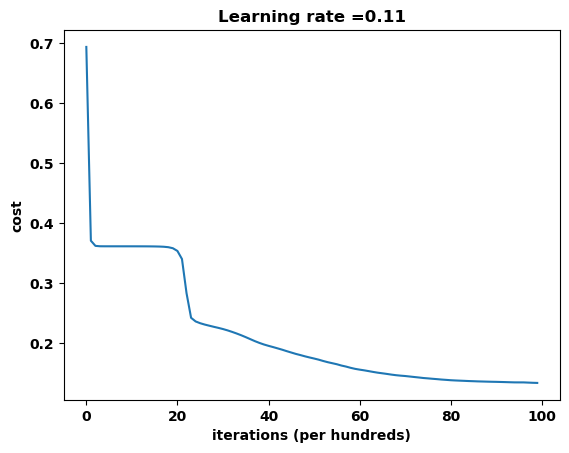

In [47]:
lr = 0.11
layers_dims_list = [43, 20, 6, 1]
parameters = L_layer_model(X_train_scaled, y_train, layers_dims, learning_rate=lr, num_iterations = 10000, print_cost = True)
predictions = predict(X_test_scaled, y_test, parameters)

In [52]:
predictions = predict(X_test_scaled, y_test, parameters)

In [53]:
y_pred = pd.Series(predictions[0].flatten())
y_test = pd.Series(y_test.flatten())
roc_value = roc_auc_score(y_test, y_pred)
print("ROC AUC: ", np.round(roc_value, 3))

ROC AUC:  0.665


In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       807
           1       0.41      0.40      0.41        98

    accuracy                           0.87       905
   macro avg       0.67      0.66      0.67       905
weighted avg       0.87      0.87      0.87       905



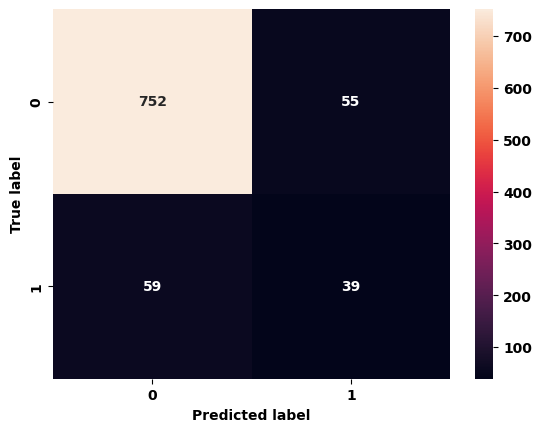

In [55]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

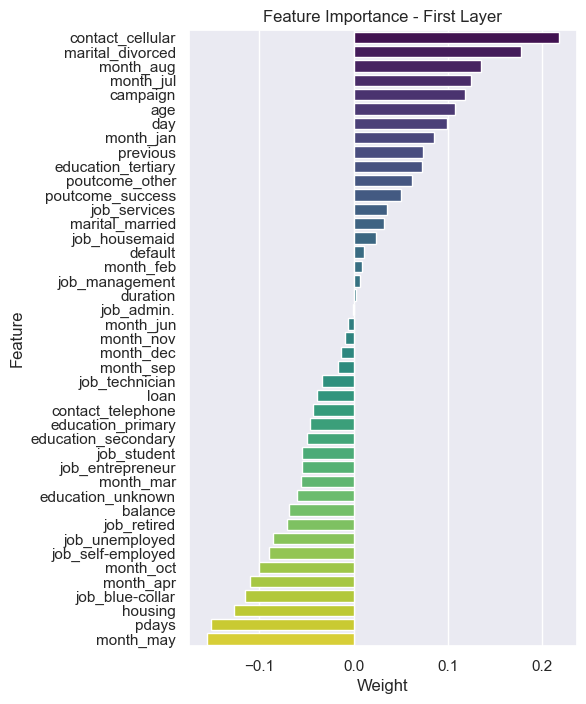

In [59]:
weights = np.sum(np.abs(parameters["W1"]), axis=0)
weights = np.median((parameters["W1"]), axis=0)
cols = df.drop(columns = ["y"]).columns.to_list()
features = pd.DataFrame({"feature": cols, "weight": weights}).sort_values(by="weight", ascending=False)

sns.set(rc={'figure.figsize': (5, 8)})
sns.barplot(data=features, x="weight", y="feature", palette="viridis")
plt.title("Feature Importance - First Layer")
plt.xlabel("Weight")
plt.ylabel("Feature")
plt.show()

# Berechne mit Gewichtung

In [62]:
def compute_class_weights(y_train):
    """
    Berechnet class weights basierend auf der Verteilung in y_train.
    
    Argument:
    y_train -- numpy array der Form (1, m), Werte 0 oder 1
    
    Rückgabe:
    class_weights -- Tuple (weight_for_0, weight_for_1)
    """
    m = y_train.shape[1]
    n_0 = np.sum(y_train == 0)
    n_1 = np.sum(y_train == 1)

    weight_0 = m / (2 * n_0)
    weight_1 = m / (2 * n_1)

    return (weight_0, weight_1)

In [85]:
class_weights = compute_class_weights(y_train)
class_weights

(0.5662386470404008, 4.274231678486998)

In [109]:
class_weights = (0.5, 6.0)

In [117]:
results = []  
learning_rates = [0.44, 0.42,0.4, 0.38, 0.36, 0.34, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14]
#learning_rates = [0.135, 0.13, 0.125, 0.12, 0.115, 0.11]
layers_dims_list = [[43, 20, 6, 1]]
num_iterations = 2500
print(len(layers_dims_list)* len(learning_rates), "models to be trained")

for lr in learning_rates:
    predictions = np.zeros((1, X_test.shape[1]))
    for layers_dims in layers_dims_list:
        parameters = L_layer_model(X_train_scaled, y_train, layers_dims, learning_rate=lr, num_iterations = 2500, print_cost = False, class_weights=class_weights)
        predictions = predict(X_test_scaled, y_test, parameters)
        y_pred = pd.Series(predictions[0].flatten())
        try:
            roc_value = roc_auc_score(y_test.to_numpy().flatten(), y_pred)
        except ValueError as e:
            print("ROC AUC skipped due to error:", e)
            continue
        
        if predictions.sum() > 1 and roc_value > 0.5:
            results.append({
                "layer_dims": layers_dims,
                "num_iterations": num_iterations,
                "learning_rate": lr,
                "parameters": parameters,
                "roc_auc": np.round(roc_value,3),
                "predictions": predictions
            })

16 models to be trained


In [118]:
print("Gefundene Kombinationen")
res = pd.DataFrame(results).sort_values(by="roc_auc", ascending=False).reset_index(drop=True).head(10)
res.head()

Gefundene Kombinationen


,layer_dims,num_iterations,learning_rate,parameters,roc_auc,predictions
0,"[43, 20, 6, 1]",2500,0.24,"{'W1': [[0.2544776073319375, -0.07580476401677...",0.745,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,..."
1,"[43, 20, 6, 1]",2500,0.30,"{'W1': [[0.3084973366516969, -0.05303054500202...",0.709,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,..."
2,"[43, 20, 6, 1]",2500,0.34,"{'W1': [[0.15160245037361134, -0.0873377205594...",0.707,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."
3,"[43, 20, 6, 1]",2500,0.40,"{'W1': [[0.35394201241095763, -0.1323719320228...",0.706,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,..."
4,"[43, 20, 6, 1]",2500,0.20,"{'W1': [[0.19033739933160868, -0.0559783471285...",0.706,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,..."


Cost after iteration 0: 0.792543
Cost after iteration 100: 1.510884
Cost after iteration 200: 1.557129
Cost after iteration 300: 1.560574
Cost after iteration 400: 1.560603
Cost after iteration 500: 1.559352
Cost after iteration 600: 1.556084
Cost after iteration 700: 1.521849
Cost after iteration 800: 0.912520
Cost after iteration 900: 0.861101
Cost after iteration 1000: 0.818607
Cost after iteration 1100: 0.771568
Cost after iteration 1200: 0.716655
Cost after iteration 1300: 0.658678
Cost after iteration 1400: 0.605805
Cost after iteration 1500: 0.552972
Cost after iteration 1600: 0.500919
Cost after iteration 1700: 0.444745
Cost after iteration 1800: 0.382775
Cost after iteration 1900: 0.309977
Cost after iteration 2000: 0.269428
Cost after iteration 2100: 0.238414
Cost after iteration 2200: 0.213812
Cost after iteration 2300: 0.189218
Cost after iteration 2400: 0.172573


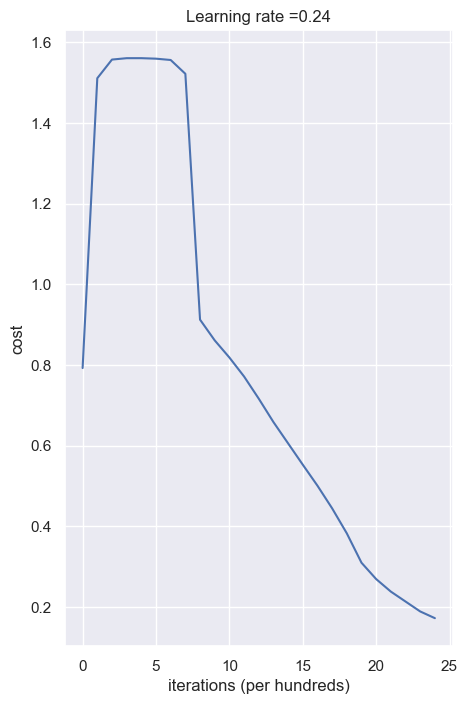

In [128]:
lr = 0.24
layers_dims_list = [43, 20, 6, 1]
num_iterations = 2500
parameters = L_layer_model(X_train_scaled, y_train, layers_dims, learning_rate=lr, num_iterations = num_iterations, print_cost = True, class_weights=class_weights)

In [129]:
predictions = predict(X_test_scaled, y_test, parameters)
predictions.sum()

112

In [131]:
y_pred = pd.Series(predictions[0].flatten())
#y_test = pd.Series(y_test.flatten())
roc_value = roc_auc_score(y_test, y_pred)
print("ROC AUC: ", np.round(roc_value, 3))

ROC AUC:  0.745


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       807
           1       0.49      0.56      0.52        98

    accuracy                           0.89       905
   macro avg       0.72      0.75      0.73       905
weighted avg       0.90      0.89      0.89       905



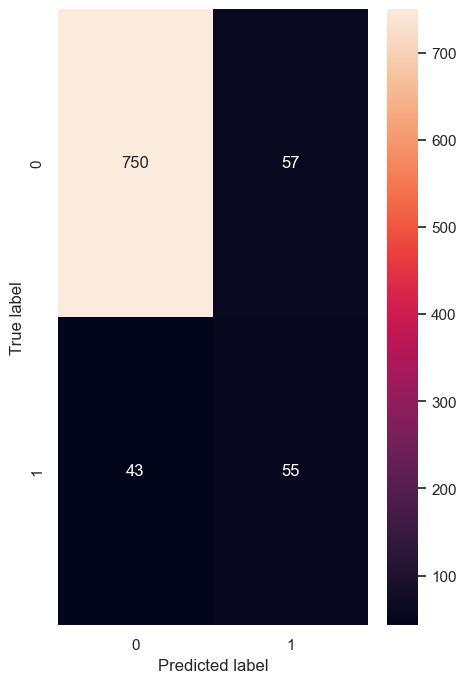

In [133]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

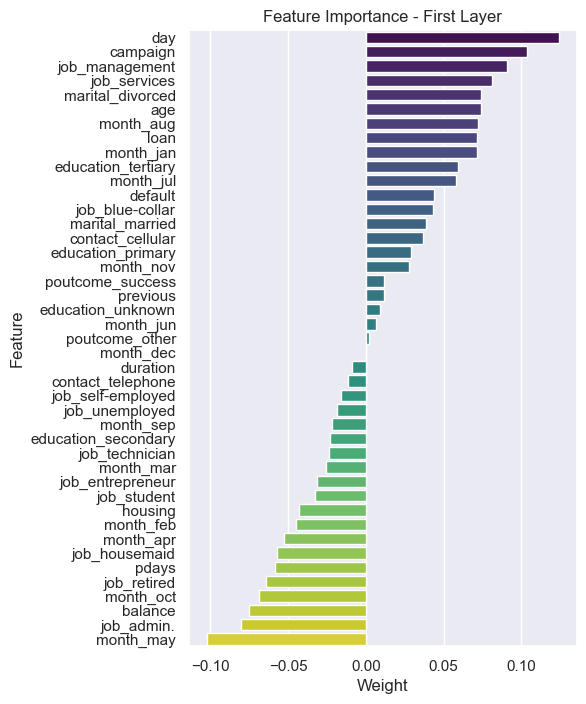

In [134]:
weights = np.sum(np.abs(parameters["W1"]), axis=0)
weights = np.median((parameters["W1"]), axis=0)
cols = df.drop(columns = ["y"]).columns.to_list()
features = pd.DataFrame({"feature": cols, "weight": weights}).sort_values(by="weight", ascending=False)

sns.set(rc={'figure.figsize': (5, 8)})
sns.barplot(data=features, x="weight", y="feature", palette="viridis")
plt.title("Feature Importance - First Layer")
plt.xlabel("Weight")
plt.ylabel("Feature")
plt.show()